<a href="https://colab.research.google.com/github/ykitaguchi77/statistics_for_articles/blob/main/Blepharoptosis_dryeye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: gdrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


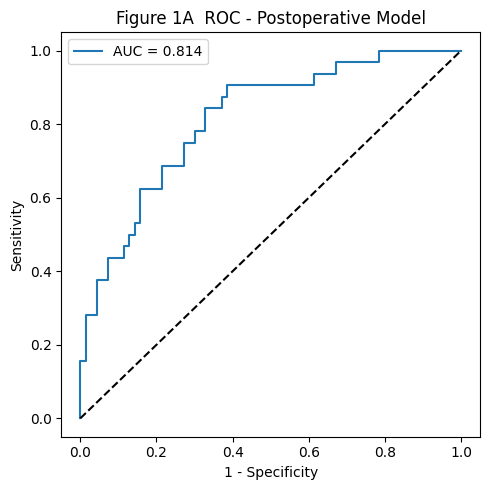

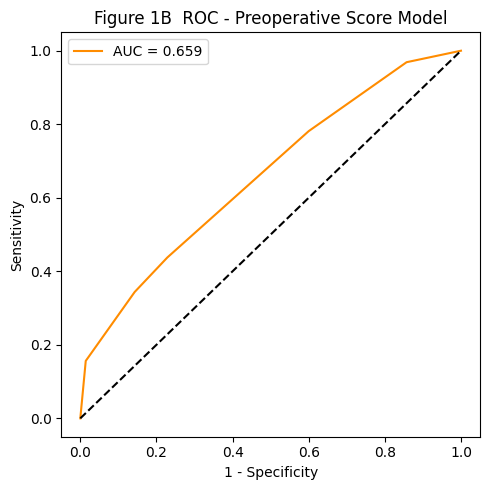

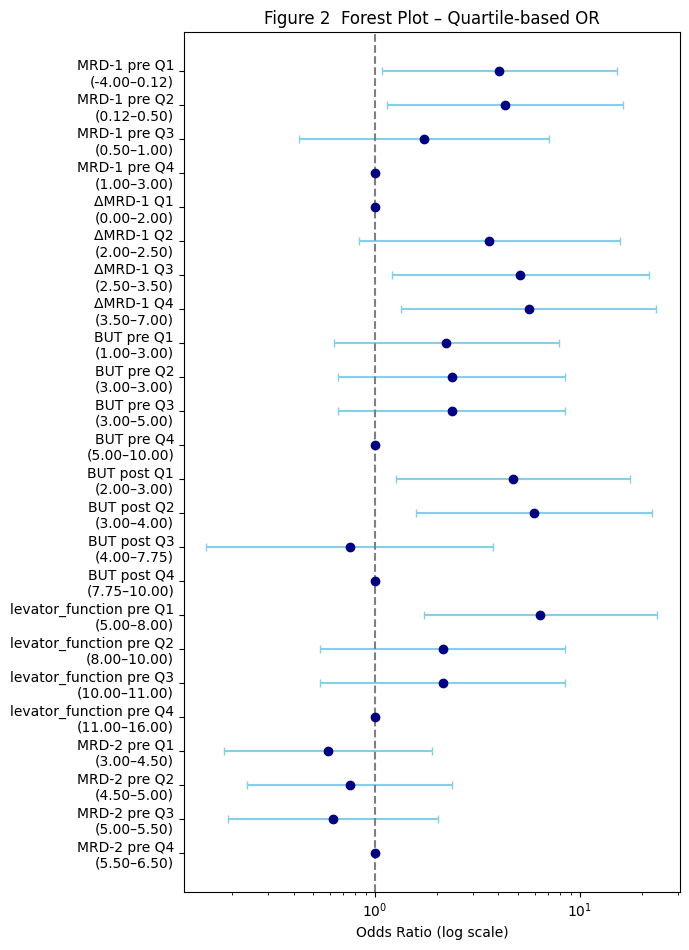

In [2]:
# Google Colabで動作する完全版スクリプト（日本語コメント付き）
# 保存先: /content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ.xlsx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import Table2x2

# Excelファイルの読み込み
file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)

# ΔMRD-1を追加
df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]

# 術前SPKが無い症例のみ抽出
df = df_all[df_all["SPK pre"] == 0].copy()

# ===============================
# Figure 1A：術後モデルのROC曲線
# ===============================
# 使用する変数（欠損除外）
post_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "MRD-2 pre", "BUT pre", "BUT post"]
df_post = df[["SPK post"] + post_cols].dropna()

X_post = sm.add_constant(df_post[post_cols])
y_post = df_post["SPK post"]

# ロジスティック回帰モデルの構築
post_model = sm.Logit(y_post, X_post).fit(disp=False)

# 予測確率とROC曲線
y_prob_post = post_model.predict(X_post)
fpr_p, tpr_p, _ = roc_curve(y_post, y_prob_post)
auc_p = roc_auc_score(y_post, y_prob_post)

# グラフ出力
plt.figure(figsize=(5, 5))
plt.plot(fpr_p, tpr_p, label=f"AUC = {auc_p:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title("Figure 1A  ROC - Postoperative Model")
plt.legend()
plt.tight_layout()
plt.savefig("Fig1A_ROC_postop.png", dpi=350)

# ===============================
# Figure 1B：スコアモデルのROC曲線
# ===============================
# スコア定義関数
def calc_score(row):
    score = 0
    if row["MRD-1 pre"] < 0.5:
        score += 2
    if row["ΔMRD-1"] >= 2.0:
        score += 1
    if row["BUT pre"] < 5:
        score += 1
    if row["levator_function pre"] < 8:
        score += 1
    return score

df["score"] = df.apply(calc_score, axis=1)
df_score = df[["score", "SPK post"]].dropna()

# モデル構築とROC
X_score = df_score[["score"]]
y_score = df_score["SPK post"]
model_score = LogisticRegression().fit(X_score, y_score)
y_prob_score = model_score.predict_proba(X_score)[:, 1]
fpr_s, tpr_s, _ = roc_curve(y_score, y_prob_score)
auc_s = roc_auc_score(y_score, y_prob_score)

# グラフ出力
plt.figure(figsize=(5, 5))
plt.plot(fpr_s, tpr_s, label=f"AUC = {auc_s:.3f}", color="darkorange")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title("Figure 1B  ROC - Preoperative Score Model")
plt.legend()
plt.tight_layout()
plt.savefig("Fig1B_ROC_preop.png", dpi=350)

# ===============================
# Figure 2：フォレストプロット（四分位OR）
# ===============================
# 対象変数
predictors = ["MRD-1 pre", "ΔMRD-1", "BUT pre", "BUT post", "levator_function pre", "MRD-2 pre"]

forest_data = []

for var in predictors:
    df_q = df[[var, "SPK post"]].dropna().copy()
    df_q["quartile"] = pd.qcut(df_q[var].rank(method="first"), 4, labels=["Q1", "Q2", "Q3", "Q4"])

    q_vals = df_q[var].quantile([0, 0.25, 0.5, 0.75, 1]).values
    ranges = {
        "Q1": f"{q_vals[0]:.2f}–{q_vals[1]:.2f}",
        "Q2": f"{q_vals[1]:.2f}–{q_vals[2]:.2f}",
        "Q3": f"{q_vals[2]:.2f}–{q_vals[3]:.2f}",
        "Q4": f"{q_vals[3]:.2f}–{q_vals[4]:.2f}"
    }

    # 基準群（リスク最小）を指定
    ref_q = "Q4" if var != "ΔMRD-1" else "Q1"

    for q in ["Q1", "Q2", "Q3", "Q4"]:
        if q == ref_q:
            forest_data.append((var, q, ranges[q], 1.0, 1.0, 1.0))
        else:
            a = ((df_q["quartile"] == q) & (df_q["SPK post"] == 1)).sum()
            b = ((df_q["quartile"] == q) & (df_q["SPK post"] == 0)).sum()
            c = ((df_q["quartile"] == ref_q) & (df_q["SPK post"] == 1)).sum()
            d = ((df_q["quartile"] == ref_q) & (df_q["SPK post"] == 0)).sum()
            # 0セル補正
            if 0 in [a, b, c, d]:
                a += 0.5; b += 0.5; c += 0.5; d += 0.5
            table = Table2x2([[a, b], [c, d]])
            or_val = table.oddsratio
            ci_low, ci_high = table.oddsratio_confint()
            forest_data.append((var, q, ranges[q], or_val, ci_low, ci_high))

# データフレーム化
forest_df = pd.DataFrame(forest_data, columns=["Variable", "Quartile", "Range", "OR", "CI_low", "CI_high"])
forest_df["Label"] = forest_df["Variable"] + " " + forest_df["Quartile"] + "\n(" + forest_df["Range"] + ")"

# プロット
plt.figure(figsize=(7, len(forest_df) * 0.4))
y_pos = np.arange(len(forest_df))[::-1]
plt.errorbar(forest_df["OR"], y_pos,
             xerr=[forest_df["OR"] - forest_df["CI_low"], forest_df["CI_high"] - forest_df["OR"]],
             fmt='o', color='navy', ecolor='skyblue', capsize=3)
plt.axvline(1, color='gray', linestyle='--')
plt.yticks(y_pos, forest_df["Label"])
plt.xscale("log")
plt.xlabel("Odds Ratio (log scale)")
plt.title("Figure 2  Forest Plot – Quartile-based OR")
plt.tight_layout()
plt.savefig("Fig2_Forest.png", dpi=350)


Libraries loaded.

--- 2. Loading and Basic Preprocessing ---
Excel file '眼瞼下垂★ドライアイ_kit.xlsx' (Sheet: '対象症例sides') loaded successfully.
Original data shape: (172, 32)
Converting key columns to numeric...
ΔMRD-1 calculated (using MRD-1 3M).
ΔMRD-2 calculated (using MRD-2 3M).
Filtered data for 'SPK pre == 0'. Shape of 'df': (102, 32)

--- 3. Generating Figure 1A: Post-operative model ROC ---
Data for Post-op model ROC: (102, 7)
Figure 1A saved as ./Fig1A_ROC_postop.png


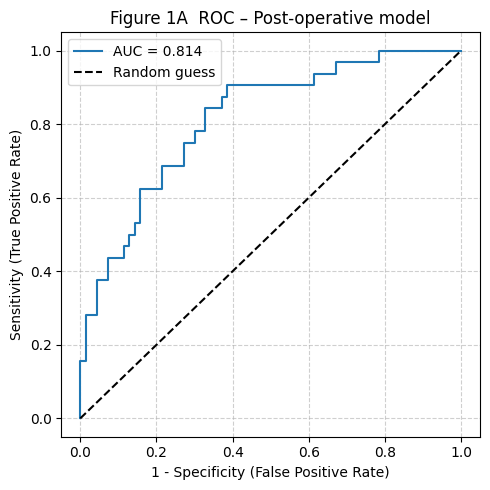


--- 4. Generating Figure 1B: Pre-operative score ROC ---
Pre-operative score calculated.
Data for Score model ROC: (102, 2)
Figure 1B saved as ./Fig1B_ROC_preop.png


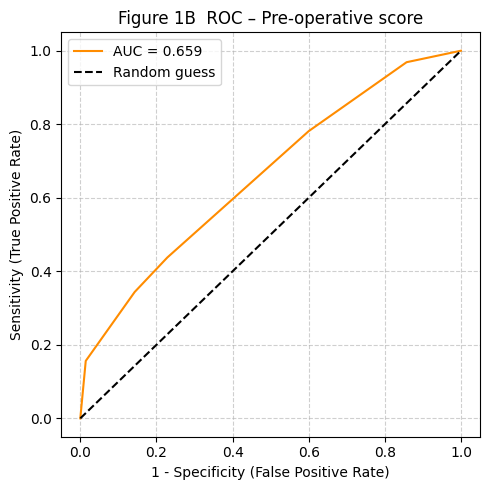


--- 5. Generating Figure 2: Forest plot (Quartile OR) ---
Data for Forest Plot: (102, 33)
Processing MRD-1 pre: 102 non-NaN rows.
 - Ref quartile for MRD-1 pre: Q4
Processing ΔMRD-1: 102 non-NaN rows.
 - Ref quartile for ΔMRD-1: Q1
Processing MRD-1 3M: 102 non-NaN rows.
 - Ref quartile for MRD-1 3M: Q4
Processing MRD-2 pre: 102 non-NaN rows.
 - Ref quartile for MRD-2 pre: Q1
Processing ΔMRD-2: 102 non-NaN rows.
 - Ref quartile for ΔMRD-2: Q1
Processing MRD-2 3M: 102 non-NaN rows.
 - Ref quartile for MRD-2 3M: Q1
Processing levator_function pre: 102 non-NaN rows.
 - Ref quartile for levator_function pre: Q4
Processing BUT pre: 102 non-NaN rows.
 - Ref quartile for BUT pre: Q4
Processing BUT post: 102 non-NaN rows.
 - Ref quartile for BUT post: Q4
Figure 2 saved as ./Fig2_Forest.png


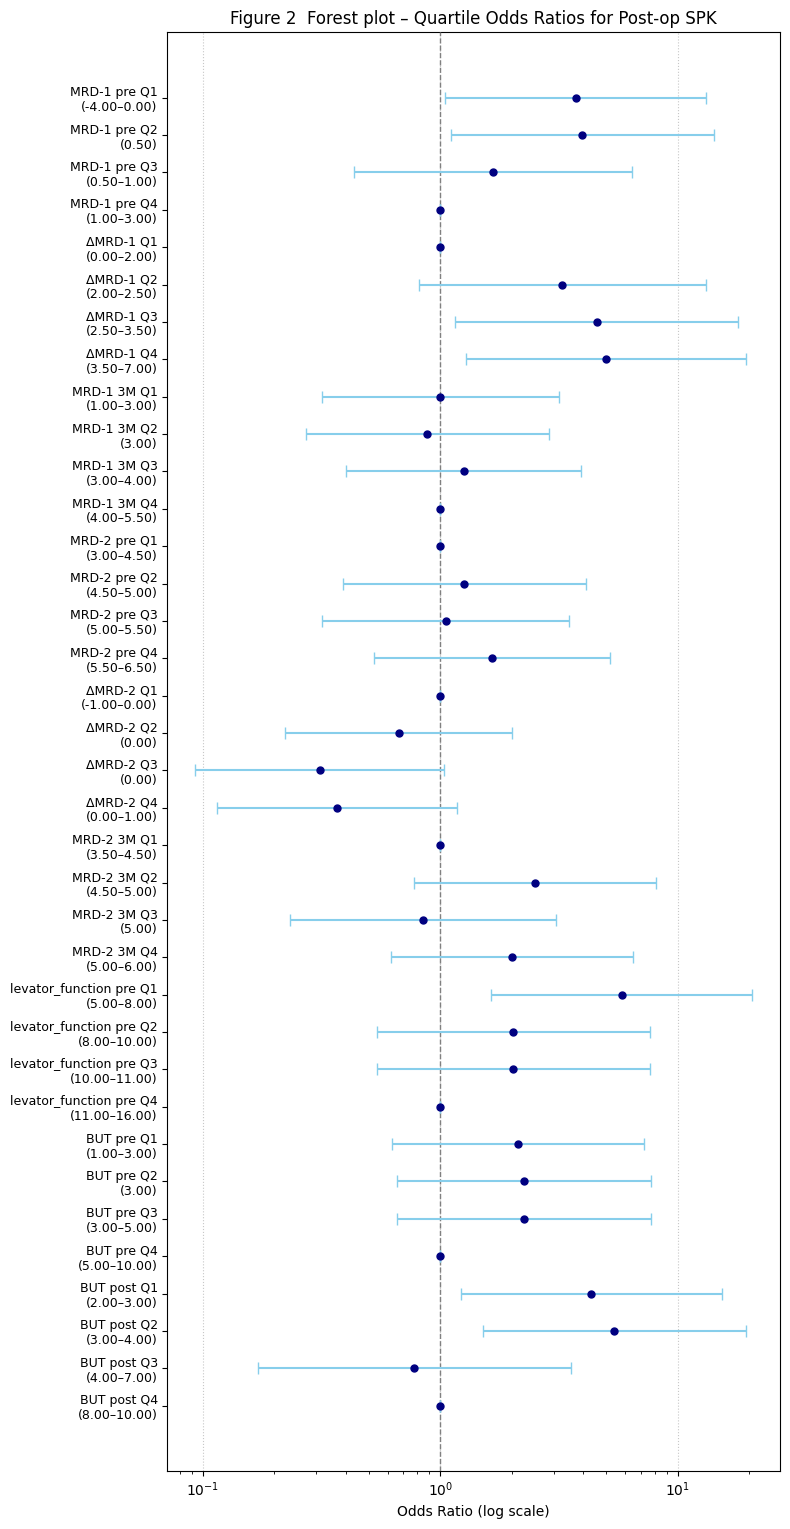


--- 6. Generating Table 1: Baseline characteristics ---

=== Table 1: Summary statistics (for subjects with SPK pre = 0) ===


,Total N (SPK pre=0),N,Missing,Mean,SD,Min,Q1,Median,Q3,Max
MRD-1 pre,102,102.0,0,0.50,1.19,-4.0,0.12,0.5,1.00,3.0
ΔMRD-1,102,102.0,0,2.74,1.33,0.0,2.00,2.5,3.50,7.0
MRD-1 3M,102,102.0,0,3.24,0.97,1.0,3.00,3.0,4.00,5.5
MRD-2 pre,102,102.0,0,4.86,0.69,3.0,4.50,5.0,5.50,6.5
ΔMRD-2,102,102.0,0,0.01,0.39,-1.0,0.00,0.0,0.00,1.0
MRD-2 3M,102,102.0,0,4.87,0.60,3.5,4.50,5.0,5.00,6.0
levator_function pre,102,102.0,0,9.53,2.20,5.0,8.00,10.0,11.00,16.0
BUT pre,102,102.0,0,4.57,2.75,1.0,3.00,3.0,5.00,10.0
BUT post,102,102.0,0,5.48,2.70,2.0,3.00,4.0,7.75,10.0



--- 7. Normality tests and Histograms ---
Shapiro-Wilk normality test (alpha = 0.05):
MRD-1 pre                 Samples=102  W=0.9111, p=0.0000 (Non-normal)


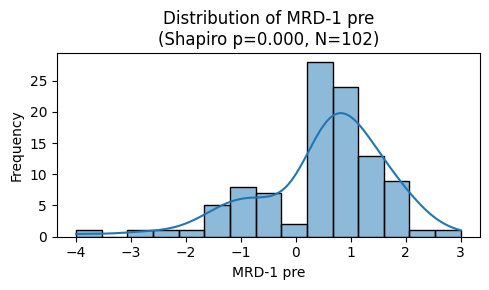

ΔMRD-1                    Samples=102  W=0.9725, p=0.0314 (Non-normal)


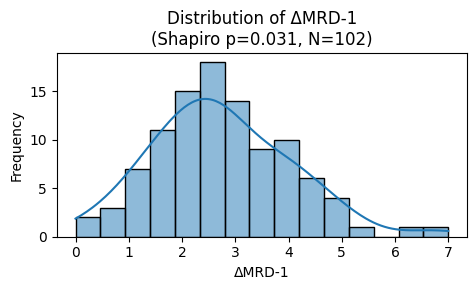

MRD-1 3M                  Samples=102  W=0.9517, p=0.0009 (Non-normal)


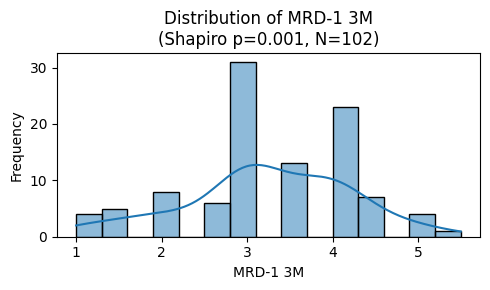

MRD-2 pre                 Samples=102  W=0.9464, p=0.0004 (Non-normal)


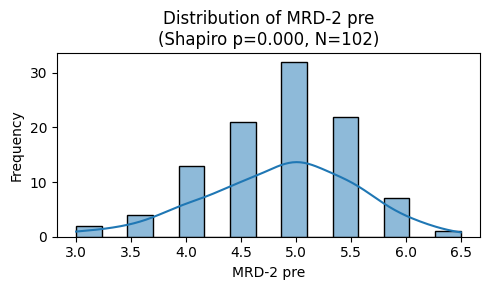

ΔMRD-2                    Samples=102  W=0.8284, p=0.0000 (Non-normal)


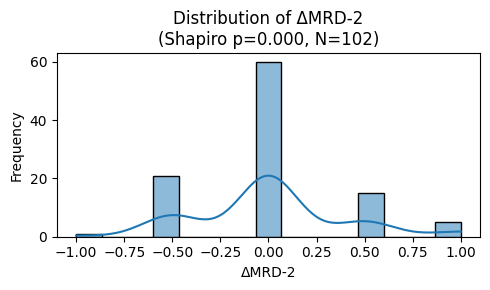

MRD-2 3M                  Samples=102  W=0.9200, p=0.0000 (Non-normal)


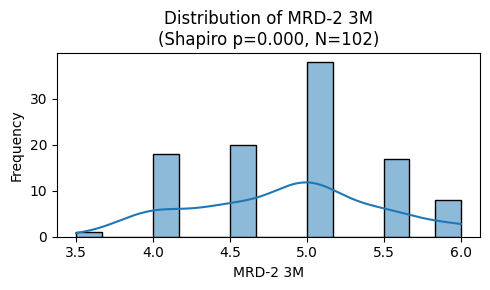

levator_function pre      Samples=102  W=0.9723, p=0.0304 (Non-normal)


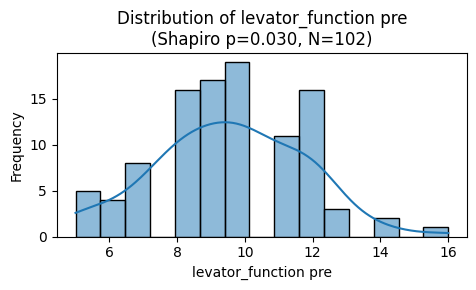

BUT pre                   Samples=102  W=0.7982, p=0.0000 (Non-normal)


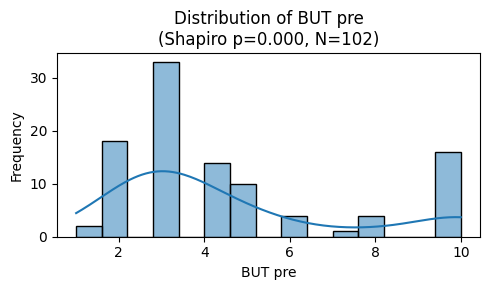

BUT post                  Samples=102  W=0.8251, p=0.0000 (Non-normal)


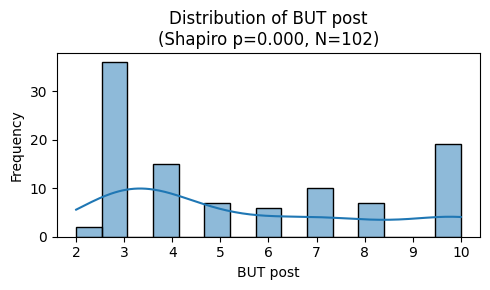


--- 8. Table 2: Univariate comparison and Multivariate logistic regression ---
Created 'df_analysis' for Table 2. Shape: (102, 33)

=== Univariate Analysis ===

--- Univariate Analysis Summary ---


,Variable,N (SPK=0),Mean (0),SD (0),N (SPK=1),Mean (1),SD (1),Test,p-value
0,MRD-1 pre,70,0.64,1.20,32,0.17,1.11,M-Whitney U,0.0198
1,ΔMRD-1,70,2.54,1.41,32,3.17,1.03,M-Whitney U,0.0065
2,MRD-1 3M,70,3.19,1.01,32,3.34,0.89,M-Whitney U,0.6292
3,MRD-2 pre,70,4.80,0.66,32,5.00,0.74,M-Whitney U,0.1626
4,ΔMRD-2,70,0.04,0.34,32,-0.05,0.46,M-Whitney U,0.1765
5,MRD-2 3M,70,4.84,0.60,32,4.95,0.59,M-Whitney U,0.2684
6,levator_function pre,70,10.01,2.05,32,8.47,2.17,Welch's t,0.0013
7,BUT pre,70,4.81,2.91,32,4.03,2.32,M-Whitney U,0.2942
8,BUT post,70,6.03,2.66,32,4.28,2.41,M-Whitney U,0.0007



=== Multivariate Logistic Regression ===
Data for Multivariate model (after dropna): (102, 10)
                   Multivariate Logistic Regression Results                   
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                       94
Method:                           MLE   Df Model:                            7
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.2359
Time:                        13:16:12   Log-Likelihood:                -48.479
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 9.740e-05
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.2205      2.164      0.102      0.919      -4.021       4.462
MRD-1

,CI 2.5%,CI 97.5%,Odds Ratio
const,0.018,86.666,1.247
MRD-1 pre,NaN,NaN,1.168
ΔMRD-1,NaN,NaN,1.089
MRD-1 3M,NaN,NaN,1.271
MRD-2 pre,0.000,inf,1.359
ΔMRD-2,0.000,inf,1.454
MRD-2 3M,0.000,inf,1.977
levator_function pre,0.450,0.811,0.604
BUT pre,0.753,1.173,0.940
BUT post,0.518,0.864,0.669



--- 9. Stepwise variable selection based on AIC ---
Null model AIC = 128.90
Iter 1: Add levator_function pre      New AIC = 119.34
Iter 2: Add BUT post                  New AIC = 110.85
Iter 3: Add MRD-2 3M                  New AIC = 107.13

=== Final Selected Model (AIC) ===
                             Stepwise AIC Result                              
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            3
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.2188
Time:                        13:16:12   Log-Likelihood:                -49.566
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 4.069e-06
                           coef    std err          z      P>|z|      [0.025      0.975]
-

,CI 2.5%,CI 97.5%,OR
const,0.023,70.134,1.263
levator_function pre,0.483,0.810,0.625
BUT post,0.545,0.871,0.689
MRD-2 3M,1.169,7.166,2.895



Selected variables by AIC: ['levator_function pre', 'BUT post', 'MRD-2 3M']

--- 10. Forest Plot OR and p-value raw data ---
Displaying the data used for the Forest Plot (Figure 2):


,Variable,Quartile,Range,OR,CI_low,CI_high,P_value
0,MRD-1 pre,Q1,-4.00–0.00,3.710,1.045,13.175,0.0644
1,MRD-1 pre,Q2,0.50,3.966,1.109,14.179,0.0337
2,MRD-1 pre,Q3,0.50–1.00,1.667,0.434,6.405,0.4986
3,MRD-1 pre,Q4,1.00–3.00,1.000,1.000,1.000,NaN
4,ΔMRD-1,Q1,0.00–2.00,1.000,1.000,1.000,NaN
5,ΔMRD-1,Q2,2.00–2.50,3.261,0.812,13.095,0.0975
6,ΔMRD-1,Q3,2.50–3.50,4.548,1.157,17.885,0.0266
7,ΔMRD-1,Q4,3.50–7.00,4.982,1.282,19.361,0.0266
8,MRD-1 3M,Q1,1.00–3.00,1.000,0.317,3.154,1.0000
9,MRD-1 3M,Q2,3.00,0.882,0.273,2.856,1.0000



--- 11. Risk Score Calculation and Evaluation ---
Risk score calculated and added.


,SPK post,risk_score,MRD-1 pre,ΔMRD-1,BUT pre,levator_function pre
0,0,3,-0.5,2.5,10.0,9.0
1,0,0,0.5,1.5,10.0,9.0
3,0,4,-1.0,5.0,3.0,9.0
4,1,3,0.5,4.0,4.0,5.0
5,1,3,0.5,4.0,4.0,5.0



=== SPK Incidence by Risk Score ===


,risk_score,Total,SPK Cases,SPK Rate (%)
0,0,11,1,9.1
1,1,24,6,25.0
2,2,37,11,29.7
3,3,9,3,33.3
4,4,15,6,40.0
5,5,6,5,83.3


Score rate plot saved: ./Fig_Score_SPK_Rate.png


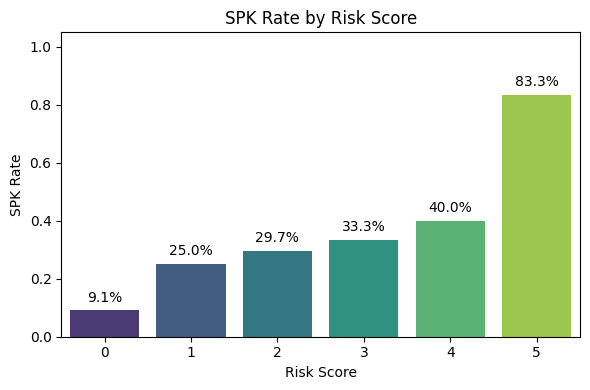


=== ROC Curve for the Risk Score ===
Score ROC curve saved: ./Fig_ROC_Score.png (AUC = 0.659)


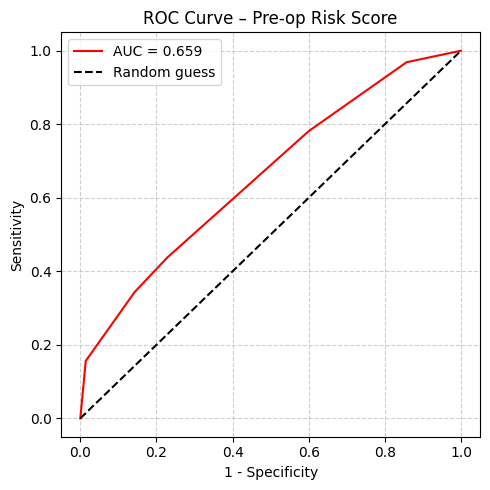


Optimal cutoff (Youden Index): Score >= 3.00 (Suggests >= 3) | Sens: 0.438, Spec: 0.771

==== 解析終了：図 (PNG) はフォルダ '.' に保存されました ====

--- 11-alt. New Scoring System including Post-operative Factors ---
New risk score (including BUT post) calculated and added.


,SPK post,new_risk_score,risk_score,MRD-1 pre,ΔMRD-1,BUT pre,levator_function pre,BUT post
0,0,3,3,-0.5,2.5,10.0,9.0,10.0
1,0,0,0,0.5,1.5,10.0,9.0,10.0
3,0,5,4,-1.0,5.0,3.0,9.0,3.0
4,1,3,3,0.5,4.0,4.0,5.0,10.0
5,1,3,3,0.5,4.0,4.0,5.0,6.0



=== SPK Incidence by New Risk Score (0-6 points) ===


,new_risk_score,Total,SPK Cases,SPK Rate (%)
0,0,8,0,0.0
1,1,17,2,11.8
2,2,36,11,30.6
3,3,18,8,44.4
4,4,8,1,12.5
5,5,12,7,58.3
6,6,3,3,100.0


New score rate plot saved: ./Fig_New_Score_SPK_Rate.png


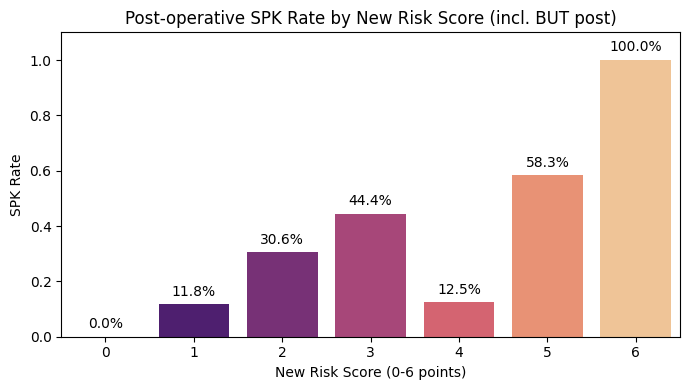


=== ROC Curve Comparison: New vs. Original Score ===
Score ROC comparison plot saved: ./Fig_ROC_Score_Comparison.png


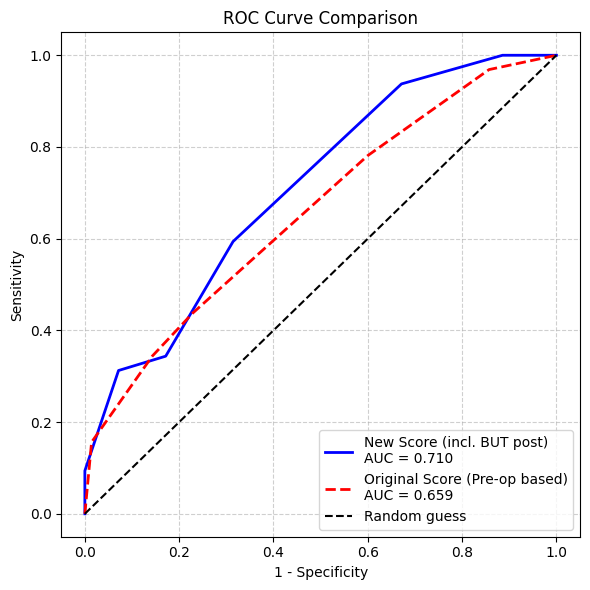


AUC Comparison: New Score = 0.710, Original Score = 0.659
The new score including BUT post shows improved discriminative ability.

Optimal cutoff for New Score (Youden Index): Score >= 3.00 (Suggests >= 3) | Sens: 0.594, Spec: 0.686

==== 解析終了：図 (PNG) はフォルダ '.' に保存されました ====


In [25]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：Google Colab用フルスクリプト Ver.Corrected_3M
# （日本語コメント付き・350 dpiで図を保存・Forest Plot p値・単変量結果・スコアリング追加）
# =============================================================

# ───────────────────────────────────────────
# 0) Google Drive をマウント（既にマウント済ならスキップ）
# ───────────────────────────────────────────
# from google.colab import drive
# try:
#     drive.mount('/content/drive')
#     print("Google Drive mounted successfully.")
# except Exception as e:
#     print(f"Error mounting Google Drive: {e}")
#     # exit() # 必要なら中断

# ───────────────────────────────────────────
# 1) ライブラリ読み込み
# ───────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import Table2x2
from scipy.stats import shapiro, mannwhitneyu, ttest_ind, fisher_exact
from statsmodels.formula.api import logit
from IPython.display import display
import warnings
import os

# 計算中の警告を抑制
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings('ignore', message="Method 'first' requires numeric dtype to function correctly")

print("Libraries loaded.")

# ───────────────────────────────────────────
# 2) Excel 読み込みと基本前処理
# ───────────────────────────────────────────
print("\n--- 2. Loading and Basic Preprocessing ---")
# ★ 注意: パス、シート名を確認してください
file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
sheet_name = "対象症例sides"
output_dir = "." # 図の保存先フォルダ

os.makedirs(output_dir, exist_ok=True)

try:
    df_all = pd.read_excel(file_path, sheet_name=sheet_name, header=0)
    print(f"Excel file '{os.path.basename(file_path)}' (Sheet: '{sheet_name}') loaded successfully.")
    print(f"Original data shape: {df_all.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()
except Exception as e:
    print(f"Error loading Excel file: {e}")
    exit()

# --- 主要カラムを数値型に変換 ---
print("Converting key columns to numeric...")
# ★★★ 'MRD-1 post', 'MRD-2 post' を 'MRD-1 3M', 'MRD-2 3M' に修正 ★★★
cols_to_convert = [
    "MRD-1 pre", "MRD-1 3M",
    "MRD-2 pre", "MRD-2 3M",
    "levator_function pre",
    "BUT pre", "BUT post",
    "SPK pre", "SPK post"
]
converted_cols = []
missing_cols = []
for col in cols_to_convert:
    if col in df_all.columns:
        df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
        converted_cols.append(col)
    else:
        print(f" - Warning: Column '{col}' not found, skipping conversion.")
        missing_cols.append(col)

if "SPK pre" not in converted_cols or "SPK post" not in converted_cols:
     print(f"Error: Required outcome columns ('SPK pre' or 'SPK post') are missing or failed conversion. Cannot proceed.")
     exit()

# --- ΔMRD を計算 ---
try:
    # ★★★ 計算に 'MRD-1 3M', 'MRD-2 3M' を使用するように修正 ★★★
    if "MRD-1 3M" in df_all.columns and "MRD-1 pre" in df_all.columns:
        df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
        print("ΔMRD-1 calculated (using MRD-1 3M).")
    else:
        print("Warning: Could not calculate ΔMRD-1 (MRD-1 3M or MRD-1 pre missing).")
        df_all["ΔMRD-1"] = np.nan

    if "MRD-2 3M" in df_all.columns and "MRD-2 pre" in df_all.columns:
        df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
        print("ΔMRD-2 calculated (using MRD-2 3M).")
    else:
        print("Warning: Could not calculate ΔMRD-2 (MRD-2 3M or MRD-2 pre missing).")
        df_all["ΔMRD-2"] = np.nan
except Exception as e:
    print(f"Error during ΔMRD calculation: {e}")
    df_all["ΔMRD-1"] = np.nan
    df_all["ΔMRD-2"] = np.nan

# --- 術前SPKなし症例のみ解析対象 ('df' を作成) ---
df = df_all[df_all["SPK pre"] == 0].copy()
print(f"Filtered data for 'SPK pre == 0'. Shape of 'df': {df.shape}")
if df.empty:
    print("Error: No data remaining after filtering for 'SPK pre == 0'. Cannot proceed.")
    exit()

# --- SPK post の存在確認 ---
if "SPK post" not in df.columns:
    print("Error: 'SPK post' column not found in the filtered data 'df'.")
    exit()

# ───────────────────────────────────────────
# 3) Figure 1A：術後モデル（BUT post 含む）ROC
# ───────────────────────────────────────────
print("\n--- 3. Generating Figure 1A: Post-operative model ROC ---")
# ★モデルに含める変数リストを確認 (ΔMRDを使用し、3M値自体は含めない)
post_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre",
             "MRD-2 pre", "BUT pre", "BUT post"]

missing_cols_post = [col for col in post_cols + ["SPK post"] if col not in df.columns]
if missing_cols_post:
    print(f"Error for Figure 1A: Missing columns in 'df': {', '.join(missing_cols_post)}")
else:
    df_post_filt = df[df["SPK post"].isin([0, 1])].copy()
    df_post = df_post_filt[["SPK post"] + post_cols].dropna()
    print(f"Data for Post-op model ROC: {df_post.shape}")

    if len(df_post) < 10 or df_post["SPK post"].nunique() < 2:
        print("Warning for Figure 1A: Insufficient data or only one class present. Skipping ROC.")
    else:
        y_post = df_post["SPK post"].astype(int)
        X_post = sm.add_constant(df_post[post_cols], has_constant='add')
        try:
            post_model = sm.Logit(y_post, X_post).fit(disp=False)
            y_prob_post = post_model.predict(X_post)
            fpr_p, tpr_p, _ = roc_curve(y_post, y_prob_post)
            auc_p = roc_auc_score(y_post, y_prob_post)

            plt.figure(figsize=(5, 5))
            plt.plot(fpr_p, tpr_p, label=f"AUC = {auc_p:.3f}")
            plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
            plt.xlabel("1 - Specificity (False Positive Rate)")
            plt.ylabel("Sensitivity (True Positive Rate)")
            plt.title("Figure 1A  ROC – Post-operative model")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            fig1a_path = os.path.join(output_dir, "Fig1A_ROC_postop.png")
            plt.savefig(fig1a_path, dpi=350)
            print(f"Figure 1A saved as {fig1a_path}")
            plt.show()
        except Exception as e:
            print(f"Error during Figure 1A generation: {e}")

# ───────────────────────────────────────────
# 4) Figure 1B：術前4因子スコア ROC
# ───────────────────────────────────────────
print("\n--- 4. Generating Figure 1B: Pre-operative score ROC ---")
# ★スコア計算に使う術前因子リストを確認
score_cols_req = ["MRD-1 pre", "ΔMRD-1", "BUT pre", "levator_function pre", "SPK post"]
missing_cols_score = [col for col in score_cols_req if col not in df.columns]
if missing_cols_score:
    print(f"Error for Figure 1B: Missing columns for score calculation: {', '.join(missing_cols_score)}")
else:
    def calc_score(row): # スコアリングルールを確認
        score = 0
        if pd.notna(row["MRD-1 pre"]) and row["MRD-1 pre"] < 0.5: score += 2
        if pd.notna(row["ΔMRD-1"])   and row["ΔMRD-1"]   >= 2.0: score += 1
        if pd.notna(row["BUT pre"])   and row["BUT pre"]   < 5:   score += 1
        if pd.notna(row["levator_function pre"]) and row["levator_function pre"] < 8: score += 1
        return score

    df["preop_score"] = df.apply(calc_score, axis=1)
    print("Pre-operative score calculated.")

    df_score_filt = df[df["SPK post"].isin([0, 1])].copy()
    df_score = df_score_filt[["preop_score", "SPK post"]].dropna(subset=["SPK post"])
    print(f"Data for Score model ROC: {df_score.shape}")

    if len(df_score) < 10 or df_score["SPK post"].nunique() < 2:
         print("Warning for Figure 1B: Insufficient data or only one class present. Skipping ROC.")
    else:
        X_score = df_score[["preop_score"]]
        y_score = df_score["SPK post"].astype(int)
        try:
            model_score = LogisticRegression(solver='liblinear')
            model_score.fit(X_score, y_score)
            y_prob_score = model_score.predict_proba(X_score)[:, 1]
            fpr_s, tpr_s, _ = roc_curve(y_score, y_prob_score)
            auc_s = roc_auc_score(y_score, y_prob_score)

            plt.figure(figsize=(5, 5))
            plt.plot(fpr_s, tpr_s, color="darkorange", label=f"AUC = {auc_s:.3f}")
            plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
            plt.xlabel("1 - Specificity (False Positive Rate)")
            plt.ylabel("Sensitivity (True Positive Rate)")
            plt.title("Figure 1B  ROC – Pre-operative score")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            fig1b_path = os.path.join(output_dir, "Fig1B_ROC_preop.png")
            plt.savefig(fig1b_path, dpi=350)
            print(f"Figure 1B saved as {fig1b_path}")
            plt.show()
        except Exception as e:
            print(f"Error during Figure 1B generation: {e}")

# ───────────────────────────────────────────
# 5) Figure 2：フォレストプロット（四分位 OR）
# ───────────────────────────────────────────
print("\n--- 5. Generating Figure 2: Forest plot (Quartile OR) ---")
# ★★★ predictors リストを '3M' に修正 ★★★
predictors = ["MRD-1 pre", "ΔMRD-1", "MRD-1 3M", "MRD-2 pre", "ΔMRD-2", "MRD-2 3M",
              "levator_function pre", "BUT pre", "BUT post"]

forest_rows = []
forest_df = pd.DataFrame() # 初期化
missing_cols_forest = [col for col in predictors + ["SPK post"] if col not in df.columns]
if missing_cols_forest:
    print(f"Error for Figure 2: Missing columns in 'df': {', '.join(missing_cols_forest)}")
else:
    df_forest_filt = df[df["SPK post"].isin([0, 1])].copy()
    df_forest_filt["SPK post"] = df_forest_filt["SPK post"].astype(int)
    print(f"Data for Forest Plot: {df_forest_filt.shape}")

    for var in predictors:
        if var not in df_forest_filt.columns: continue
        sub = df_forest_filt[[var, "SPK post"]].dropna()
        print(f"Processing {var}: {len(sub)} non-NaN rows.")
        if len(sub) < 4 or sub[var].nunique() < 2: continue

        try:
            n_quantiles = min(4, sub[var].nunique())
            if n_quantiles < 2: continue
            labels = [f"Q{i+1}" for i in range(n_quantiles)]
            sub["q"] = pd.qcut(sub[var].rank(method='first'), n_quantiles, labels=labels, duplicates='drop')
        except Exception as e:
            print(f" - Failed quartile creation for {var}: {e}.")
            continue

        existing_quartiles = sub["q"].cat.categories.tolist()
        ranges = {q_label: f"{sub[sub['q'] == q_label][var].min():.2f}–{sub[sub['q'] == q_label][var].max():.2f}"
                  if sub[sub['q'] == q_label][var].min() != sub[sub['q'] == q_label][var].max()
                  else f"{sub[sub['q'] == q_label][var].min():.2f}"
                  for q_label in existing_quartiles}

        # ★★★ 参照カテゴリ決定ロジックを '3M' に修正 ★★★
        ref_q = "Q1" if var in ["ΔMRD-1", "MRD-2 pre", "ΔMRD-2", "MRD-2 3M"] else existing_quartiles[-1]
        if ref_q not in existing_quartiles: ref_q = existing_quartiles[-1]
        print(f" - Ref quartile for {var}: {ref_q}")

        for q in existing_quartiles:
            range_str = ranges.get(q, "N/A")
            if q == ref_q:
                forest_rows.append((var, q, range_str, 1.0, 1.0, 1.0, np.nan))
                continue
            a_orig = ((sub["q"]==q) & (sub["SPK post"]==1)).sum()
            b_orig = ((sub["q"]==q) & (sub["SPK post"]==0)).sum()
            c_orig = ((sub["q"]==ref_q) & (sub["SPK post"]==1)).sum()
            d_orig = ((sub["q"]==ref_q) & (sub["SPK post"]==0)).sum()
            a, b, c, d = a_orig+0.5, b_orig+0.5, c_orig+0.5, d_orig+0.5
            or_val, ci_low, ci_high, p_val = np.nan, np.nan, np.nan, np.nan
            try:
                table = Table2x2([[a, b], [c, d]])
                or_val = table.oddsratio; ci_low, ci_high = table.oddsratio_confint()
                if np.sum([[a_orig, b_orig], [c_orig, d_orig]]) > 0:
                    _, p_val = fisher_exact([[a_orig, b_orig], [c_orig, d_orig]], alternative='two-sided')
            except Exception as e: pass
            forest_rows.append((var, q, range_str, or_val, ci_low, ci_high, p_val))

    if forest_rows:
        forest_df = pd.DataFrame(forest_rows, columns=["Variable", "Quartile", "Range", "OR", "CI_low", "CI_high", "P_value"])
        def create_label(row): return f"{row['Variable']} {row['Quartile']}\n({row['Range']})"
        forest_df["Label"] = forest_df.apply(create_label, axis=1)

        plt.figure(figsize=(8, max(5, len(forest_df) * 0.45)))
        y_pos = np.arange(len(forest_df))[::-1]
        plot_data = forest_df.dropna(subset=['OR', 'CI_low', 'CI_high']).copy()
        y_pos_plot = y_pos[forest_df[['OR', 'CI_low', 'CI_high']].notna().all(axis=1)]

        if not plot_data.empty:
            clip_min, clip_max = 1e-3, 1e3
            plot_data['OR_plot'] = np.clip(plot_data['OR'], clip_min, clip_max)
            plot_data['CI_low_plot'] = np.clip(plot_data['CI_low'], clip_min, clip_max)
            plot_data['CI_high_plot'] = np.clip(plot_data['CI_high'], clip_min, clip_max)
            xerr_low = np.maximum(plot_data['OR_plot'] - plot_data['CI_low_plot'], 0)
            xerr_high = np.maximum(plot_data['CI_high_plot'] - plot_data['OR_plot'], 0)

            plt.errorbar(plot_data['OR_plot'], y_pos_plot, xerr=[xerr_low, xerr_high],
                         fmt='o', color='navy', ecolor='skyblue', capsize=4, markersize=5, zorder=10)
            plt.axvline(1, color='gray', linestyle='--', linewidth=1, zorder=5)
            plt.yticks(y_pos, forest_df["Label"], fontsize=9)
            plt.xscale("log")
            plt.xlabel("Odds Ratio (log scale)")
            plt.title("Figure 2  Forest plot – Quartile Odds Ratios for Post-op SPK")
            plt.grid(axis='x', linestyle=':', alpha=0.7)
            plt.tight_layout(rect=[0, 0.02, 1, 0.97])
            fig2_path = os.path.join(output_dir, "Fig2_Forest.png")
            plt.savefig(fig2_path, dpi=350)
            print(f"Figure 2 saved as {fig2_path}")
            plt.show()
        else: print("Forest plot not generated (no valid data).")
    else: print("Forest plot not generated (no data processed).")

# ───────────────────────────────────────────
# 6) Table 1：基本統計量
# ───────────────────────────────────────────
print("\n--- 6. Generating Table 1: Baseline characteristics ---")
# ★ Table 1 に含める変数リスト (predictors リストを使用)
table1_cols = predictors
missing_cols_table1 = [col for col in table1_cols if col not in df.columns]
if missing_cols_table1:
     print(f"Error for Table 1: Missing columns in 'df': {', '.join(missing_cols_table1)}")
else:
    table1 = df[table1_cols].describe(percentiles=[.25, .5, .75]).T
    table1 = table1.rename(columns={"count": "N", "50%": "Median", "25%": "Q1", "75%": "Q3",
                                     "mean": "Mean", "std": "SD", "min": "Min", "max": "Max"})
    table1["Missing"] = df[table1_cols].isna().sum()
    table1["Total N (SPK pre=0)"] = len(df)
    table1 = table1[["Total N (SPK pre=0)", "N", "Missing", "Mean", "SD", "Min", "Q1", "Median", "Q3", "Max"]]
    print("\n=== Table 1: Summary statistics (for subjects with SPK pre = 0) ===")
    display(table1.round(2))

# ───────────────────────────────────────────
# 7) 正規性検定とヒストグラム
# ───────────────────────────────────────────
print("\n--- 7. Normality tests and Histograms ---")
# ★ 正規性検定対象リスト (predictors リストを使用)
normality_cols = predictors
missing_cols_norm = [col for col in normality_cols if col not in df.columns]
if missing_cols_norm:
     print(f"Error for Normality tests: Missing columns: {', '.join(missing_cols_norm)}")
else:
    alpha = 0.05
    print(f"Shapiro-Wilk normality test (alpha = {alpha}):")
    for col in normality_cols:
        if col not in df.columns: continue
        d = df[col].dropna()
        print(f"{col:<25}", end="")

        if len(d) >= 3:
            try:
                stat, p_shapiro = shapiro(d)
                normality = "Normal" if p_shapiro > alpha else "Non-normal"
                print(f" Samples={len(d):<4} W={stat:.4f}, p={p_shapiro:.4f} ({normality})")
                plt.figure(figsize=(5, 3))
                sns.histplot(d, kde=True, bins=15)
                plt.title(f"Distribution of {col}\n(Shapiro p={p_shapiro:.3f}, N={len(d)})")
                plt.xlabel(col); plt.ylabel("Frequency"); plt.tight_layout()
                plt.show()
            except Exception as e: print(f" Error: {e}")
        elif len(d) > 0:
            print(f" Samples={len(d):<4} Too few samples for Shapiro-Wilk test.")
            plt.figure(figsize=(5, 3)); sns.histplot(d, kde=False, bins=max(1, len(d)))
            plt.title(f"Distribution of {col} (N={len(d)})")
            plt.xlabel(col); plt.ylabel("Frequency"); plt.tight_layout(); plt.show()
        else: print(" No data available.")

# ───────────────────────────────────────────
# 8) Table 2：単変量比較 & 多変量ロジスティック
# ───────────────────────────────────────────
print("\n--- 8. Table 2: Univariate comparison and Multivariate logistic regression ---")
# ★ 解析に使用する連続変数リスト (predictors リストを使用)
continuous_vars = predictors
analysis_cols_check = continuous_vars + ["SPK post"]
df_analysis = None; univar_df = pd.DataFrame(); model_multi = None

missing_cols_analysis = [col for col in analysis_cols_check if col not in df.columns]
if missing_cols_analysis:
     print(f"Error for Table 2: Missing columns in 'df': {', '.join(missing_cols_analysis)}")
else:
    df_analysis = df[df['SPK post'].isin([0, 1])].copy()
    df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
    print(f"Created 'df_analysis' for Table 2. Shape: {df_analysis.shape}")

    if df_analysis.empty or df_analysis['SPK post'].nunique() < 2:
        print("Warning: Skipping Table 2 (Not enough data or only one SPK post class).")
    else:
        # === 単変量解析 ===
        print("\n=== Univariate Analysis ===")
        results_univar = []
        alpha = 0.05
        for col in continuous_vars:
            if col not in df_analysis.columns: continue
            g0 = df_analysis[df_analysis["SPK post"]==0][col].dropna()
            g1 = df_analysis[df_analysis["SPK post"]==1][col].dropna()
            row = {"Variable": col, "N0": len(g0), "Mean0": g0.mean(), "SD0": g0.std(),
                   "N1": len(g1), "Mean1": g1.mean(), "SD1": g1.std(),
                   "Test": "Skipped", "p-value": np.nan}
            if len(g0) >= 3 and len(g1) >= 3:
                test_name, p = "Skipped", np.nan
                try:
                    norm0 = shapiro(g0)[1] > alpha; norm1 = shapiro(g1)[1] > alpha
                    if norm0 and norm1: stat, p = ttest_ind(g0, g1, equal_var=False); test_name = "Welch's t"
                    else:
                        if g0.nunique() > 1 or g1.nunique() > 1: stat, p = mannwhitneyu(g0, g1, alternative='two-sided'); test_name = "M-Whitney U"
                        else: test_name = "Identical"; p = 1.0
                    row["Test"] = test_name; row["p-value"] = p
                except Exception: row["Test"] = "Test Error"
            results_univar.append(row)
        univar_df = pd.DataFrame(results_univar)
        print("\n--- Univariate Analysis Summary ---")
        display(univar_df.rename(columns={'N0':'N (SPK=0)', 'Mean0':'Mean (0)', 'SD0':'SD (0)',
                                           'N1':'N (SPK=1)', 'Mean1':'Mean (1)', 'SD1':'SD (1)'})
                [['Variable', 'N (SPK=0)', 'Mean (0)', 'SD (0)', 'N (SPK=1)', 'Mean (1)', 'SD (1)', 'Test', 'p-value']]
                .round({'Mean (0)': 2, 'SD (0)': 2, 'Mean (1)': 2, 'SD (1)': 2, 'p-value': 4}))

        # === 多変量ロジスティック回帰 ===
        print("\n=== Multivariate Logistic Regression ===")
        mv_cols = ["SPK post"] + continuous_vars
        df_mv = df_analysis[mv_cols].dropna()
        print(f"Data for Multivariate model (after dropna): {df_mv.shape}")
        min_samples_needed = len(continuous_vars) + 1
        if len(df_mv) < min_samples_needed or df_mv["SPK post"].nunique() < 2:
            print(f"Warning: Skipping multivariate analysis (Insufficient data: {len(df_mv)}/{min_samples_needed} or one class).")
        else:
            try:
                y_mv = df_mv["SPK post"]; X_mv_cont = df_mv[continuous_vars]
                X_mv = sm.add_constant(X_mv_cont, has_constant='add')
                model_multi = sm.Logit(y_mv, X_mv).fit(disp=0)
                print(model_multi.summary(title="Multivariate Logistic Regression Results",
                                          yname="SPK post", xname=["Intercept"] + continuous_vars))
                params = model_multi.params; conf = model_multi.conf_int()
                conf['Odds Ratio'] = params; conf.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                print("\n--- Odds Ratios (Multivariate Model) ---"); display(np.exp(conf).round(3))
            except Exception as e: print(f"Error during multivariate regression: {e}"); model_multi = None

# ───────────────────────────────────────────
# 9) AICベースのステップワイズ変数選択
# ───────────────────────────────────────────
print("\n--- 9. Stepwise variable selection based on AIC ---")
aic_model = None; selected_vars = []
if model_multi is not None and 'df_mv' in locals() and not df_mv.empty:
    X_step = df_mv[continuous_vars]; y_step = df_mv["SPK post"]
    # (ステップワイズ関数の定義は省略 - 前回のコードと同じ)
    def stepwise_logistic_aic(X, y, initial_list=[], verbose=True):
        included = list(initial_list); best_aic = np.inf
        null_model, null_aic = None, np.inf
        try:
            X_null = sm.add_constant(pd.DataFrame(np.ones(len(y)), index=y.index, columns=['Intercept']), has_constant='add')
            null_model = sm.Logit(y, X_null).fit(disp=0); null_aic = null_model.aic
            if verbose: print(f"Null model AIC = {null_aic:.2f}")
        except Exception as e: print(f"Error fitting null model: {e}"); return [], None
        if included:
            try:
                current_model = sm.Logit(y, sm.add_constant(X[included], has_constant='add')).fit(disp=0)
                best_aic = current_model.aic; print(f"Initial model AIC = {best_aic:.2f}")
            except Exception as e: print(f"Error initial model: {e}"); included = []; best_aic = null_aic
        else: best_aic = null_aic
        iter_count, max_iter = 0, 2*len(X.columns)+2
        while iter_count < max_iter:
            iter_count += 1; changed = False; potential_actions = []
            excluded = list(set(X.columns) - set(included))
            for new_column in excluded:
                try: model=sm.Logit(y,sm.add_constant(X[included+[new_column]],has_constant='add')).fit(disp=0); potential_actions.append((model.aic,new_column,'add'))
                except Exception: continue
            if len(included) > 0:
                for drop_column in included:
                    temp_included = [col for col in included if col != drop_column]
                    if not temp_included: aic_drop = null_aic
                    else:
                        try: model=sm.Logit(y,sm.add_constant(X[temp_included],has_constant='add')).fit(disp=0); aic_drop=model.aic
                        except Exception: continue
                    potential_actions.append((aic_drop, drop_column, 'drop'))
            if not potential_actions: break
            potential_actions.sort(key=lambda x: x[0])
            best_new_aic, best_variable, best_action = potential_actions[0]
            if best_new_aic < best_aic - 1e-6:
                best_aic=best_new_aic
                if best_action=='add': included.append(best_variable)
                else: included.remove(best_variable)
                changed=True; print(f"Iter {iter_count}: {best_action.title()} {best_variable:<25} New AIC = {best_aic:.2f}")
            else: break
            if not changed: break
        print("\n=== Final Selected Model (AIC) ===")
        final_model = None
        if included:
            try:
                final_model=sm.Logit(y,sm.add_constant(X[included],has_constant='add')).fit(disp=0)
                print(final_model.summary(title="Stepwise AIC Result",yname=y.name,xname=["Intercept"]+included))
                params_final=final_model.params; conf_final=final_model.conf_int(); conf_final['OR']=params_final; conf_final.columns=['CI 2.5%','CI 97.5%','OR']
                print("\n--- Odds Ratios (Final AIC Model) ---"); display(np.exp(conf_final).round(3))
            except Exception as e: print(f"Error final model: {e}"); final_model=null_model
        else: final_model=null_model; print("No variables selected."); print(final_model.summary())
        return included, final_model
    try:
        selected_vars, aic_model = stepwise_logistic_aic(X_step, y_step, verbose=True)
        print(f"\nSelected variables by AIC: {selected_vars}")
    except Exception as e: print(f"Error during stepwise selection: {e}"); aic_model = None; selected_vars = []
else: print("Skipping stepwise selection.")

# ───────────────────────────────────────────
# 10) Forest plot 用 OR データ表示 (p値含む)
# ───────────────────────────────────────────
print("\n--- 10. Forest Plot OR and p-value raw data ---")
if 'forest_df' in locals() and not forest_df.empty:
    print("Displaying the data used for the Forest Plot (Figure 2):")
    display_cols = ["Variable", "Quartile", "Range", "OR", "CI_low", "CI_high", "P_value"]
    display_cols = [col for col in display_cols if col in forest_df.columns]
    display(forest_df[display_cols].round({'OR': 3, 'CI_low': 3, 'CI_high': 3, 'P_value': 4}))
else: print("No data available to display for the Forest Plot.")

# ───────────────────────────────────────────
# 11) リスクスコアの計算と評価
# ───────────────────────────────────────────
print("\n--- 11. Risk Score Calculation and Evaluation ---")
if 'df_analysis' in locals() and isinstance(df_analysis, pd.DataFrame) and not df_analysis.empty:
    # (スコア計算関数の定義は省略 - 前回のコードと同じ)
    def calculate_risk_score(row):
        score = 0; score_calc_cols_check = ["MRD-1 pre","ΔMRD-1","BUT pre","levator_function pre"]
        if all(col in row.index for col in score_calc_cols_check):
             if pd.notna(row["MRD-1 pre"]) and row["MRD-1 pre"] < 0.5: score += 2
             if pd.notna(row["ΔMRD-1"]) and row["ΔMRD-1"] >= 2.0: score += 1
             if pd.notna(row["BUT pre"]) and row["BUT pre"] < 5: score += 1
             if pd.notna(row["levator_function pre"]) and row["levator_function pre"] < 8: score += 1
             return score
        else: return np.nan
    score_calc_cols = ["MRD-1 pre", "ΔMRD-1", "BUT pre", "levator_function pre"]
    missing_score_cols_eval = [col for col in score_calc_cols if col not in df_analysis.columns]
    if missing_score_cols_eval: print(f"Error calculating score for eval: Missing cols: {', '.join(missing_score_cols_eval)}")
    else:
        if 'risk_score' not in df_analysis.columns:
             df_analysis["risk_score"] = df_analysis.apply(calculate_risk_score, axis=1)
             print("Risk score calculated and added.")
        elif 'preop_score' in df_analysis.columns:
             df_analysis['risk_score'] = df_analysis['preop_score']; print("Using existing 'preop_score'.")
        else: df_analysis["risk_score"] = df_analysis.apply(calculate_risk_score, axis=1); print("Recalculated 'risk_score'.")

        if "risk_score" in df_analysis.columns and not df_analysis["risk_score"].isna().all():
            display(df_analysis[["SPK post", "risk_score"] + score_calc_cols].head())
            print("\n=== SPK Incidence by Risk Score ===")
            score_summary = df_analysis.dropna(subset=['risk_score']).groupby("risk_score")["SPK post"].agg(['count','sum','mean']).reset_index()
            if not score_summary.empty:
                score_summary=score_summary.rename(columns={'count':'Total','sum':'SPK Cases','mean':'SPK Rate'})
                score_summary["SPK Rate (%)"]=(score_summary["SPK Rate"]*100).round(1)
                display(score_summary[["risk_score","Total","SPK Cases","SPK Rate (%)"]])
                plt.figure(figsize=(6,4)); sns.barplot(x="risk_score",y="SPK Rate",data=score_summary,palette="viridis")
                plt.title("SPK Rate by Risk Score"); plt.xlabel("Risk Score"); plt.ylabel("SPK Rate")
                plt.ylim(0,max(1.05, score_summary["SPK Rate"].max()*1.1 if not score_summary["SPK Rate"].empty else 1.05))
                for index, row in score_summary.iterrows(): plt.text(index, row['SPK Rate'] + 0.02, f"{row['SPK Rate (%)']:.1f}%", color='black', ha="center", va='bottom')
                plt.tight_layout(); fig_score_rate_path=os.path.join(output_dir,"Fig_Score_SPK_Rate.png"); plt.savefig(fig_score_rate_path,dpi=350); print(f"Score rate plot saved: {fig_score_rate_path}"); plt.show()
            else: print("Could not generate score summary.")
            print("\n=== ROC Curve for the Risk Score ===")
            score_roc_data=df_analysis[["risk_score","SPK post"]].dropna()
            if len(score_roc_data)<10 or score_roc_data["SPK post"].nunique()<2: print("Warning: Insufficient data for score ROC.")
            else:
                y_true_score=score_roc_data["SPK post"]; y_pred_score=score_roc_data["risk_score"]
                fpr_score,tpr_score,thresholds_score=roc_curve(y_true_score, y_pred_score)
                auc_score=roc_auc_score(y_true_score, y_pred_score)
                plt.figure(figsize=(5,5)); plt.plot(fpr_score,tpr_score,color="red",label=f"AUC = {auc_score:.3f}"); plt.plot([0,1],[0,1],'k--',label='Random guess')
                plt.xlabel("1 - Specificity"); plt.ylabel("Sensitivity"); plt.title("ROC Curve – Pre-op Risk Score"); plt.legend(); plt.grid(True,ls='--',alpha=0.6); plt.tight_layout()
                fig_roc_score_path=os.path.join(output_dir,"Fig_ROC_Score.png"); plt.savefig(fig_roc_score_path,dpi=350); print(f"Score ROC curve saved: {fig_roc_score_path} (AUC = {auc_score:.3f})"); plt.show()
                if len(tpr_score)>1 and len(fpr_score)>1:
                    youden_index=tpr_score-fpr_score; optimal_idx=np.argmax(youden_index)
                    optimal_threshold=thresholds_score[optimal_idx]; optimal_sensitivity=tpr_score[optimal_idx]; optimal_specificity=1-fpr_score[optimal_idx]
                    practical_cutoff = np.ceil(optimal_threshold) if optimal_threshold > 0 else 0
                    print(f"\nOptimal cutoff (Youden Index): Score >= {optimal_threshold:.2f} (Suggests >= {practical_cutoff:.0f}) | Sens: {optimal_sensitivity:.3f}, Spec: {optimal_specificity:.3f}")
                else: print("\nCould not determine optimal cutoff point.")
        else: print("Risk score column could not be generated or is all NaN.")
else: print("Skipping score evaluation ('df_analysis' not available or empty).")

print("\n==========================================================")
print(f"==== 解析終了：図 (PNG) はフォルダ '{output_dir}' に保存されました ====")
print("==========================================================")


# ───────────────────────────────────────────
# 11-alt) 新しい術後因子を含むスコアリングシステムの構築と評価
# ───────────────────────────────────────────
print("\n--- 11-alt. New Scoring System including Post-operative Factors ---")

# df_analysis が存在し、空でなく、SPK post が2クラス存在するか確認
if 'df_analysis' in locals() and isinstance(df_analysis, pd.DataFrame) and not df_analysis.empty and df_analysis['SPK post'].nunique() == 2:

    # --- 新スコア計算関数の定義 ---
    def calculate_new_score(row):
        score = 0
        # 既存スコアの因子
        if pd.notna(row["MRD-1 pre"]) and row["MRD-1 pre"] < 0.5: score += 2
        if pd.notna(row["ΔMRD-1"]) and row["ΔMRD-1"] >= 2.0: score += 1
        if pd.notna(row["BUT pre"]) and row["BUT pre"] < 5:   score += 1
        if pd.notna(row["levator_function pre"]) and row["levator_function pre"] < 8: score += 1
        # 新しく追加する術後因子 (BUT post)
        if pd.notna(row["BUT post"]) and row["BUT post"] < 4: score += 1 # 1点加算
        return score

    # --- 新スコアの計算に必要な列を確認 ---
    new_score_req_cols = ["MRD-1 pre", "ΔMRD-1", "BUT pre", "levator_function pre", "BUT post"]
    missing_new_score_cols = [col for col in new_score_req_cols if col not in df_analysis.columns]

    can_evaluate_new_score = False # 評価可能フラグを初期化
    if missing_new_score_cols:
        print(f"Error calculating new score: Missing columns in df_analysis: {', '.join(missing_new_score_cols)}")
    else:
        df_analysis["new_risk_score"] = df_analysis.apply(calculate_new_score, axis=1)
        print("New risk score (including BUT post) calculated and added.")
        display(df_analysis[["SPK post", "new_risk_score", "risk_score"] + new_score_req_cols].head()) # 既存スコアも表示
        can_evaluate_new_score = True # 評価可能に設定

    # --- 新スコアの評価 (計算できた場合のみ) ---
    if can_evaluate_new_score and not df_analysis["new_risk_score"].isna().all():

        # --- スコア別 SPK 発生率 ---
        print("\n=== SPK Incidence by New Risk Score (0-6 points) ===")
        new_score_summary = df_analysis.dropna(subset=['new_risk_score']).groupby("new_risk_score")["SPK post"].agg(['count','sum','mean']).reset_index()

        if not new_score_summary.empty:
            new_score_summary=new_score_summary.rename(columns={'count':'Total','sum':'SPK Cases','mean':'SPK Rate'})
            new_score_summary["SPK Rate (%)"]=(new_score_summary["SPK Rate"]*100).round(1)
            display(new_score_summary[["new_risk_score","Total","SPK Cases","SPK Rate (%)"]])

            # 棒グラフ
            plt.figure(figsize=(7, 4))
            sns.barplot(x="new_risk_score",y="SPK Rate",data=new_score_summary,palette="magma")
            plt.title("Post-operative SPK Rate by New Risk Score (incl. BUT post)")
            plt.xlabel("New Risk Score (0-6 points)")
            plt.ylabel("SPK Rate")
            plt.ylim(0,max(1.05, new_score_summary["SPK Rate"].max()*1.1 if not new_score_summary.empty else 1.05))
            for index, row in new_score_summary.iterrows():
                 x_coord = index
                 plt.text(x_coord, row['SPK Rate'] + 0.02, f"{row['SPK Rate (%)']:.1f}%", color='black', ha="center", va='bottom')
            plt.tight_layout()
            fig_new_score_rate_path=os.path.join(output_dir,"Fig_New_Score_SPK_Rate.png")
            plt.savefig(fig_new_score_rate_path,dpi=350)
            print(f"New score rate plot saved: {fig_new_score_rate_path}")
            plt.show()
        else: print("Could not generate new score summary.")

        # --- ROC分析 (新旧スコア比較) ---
        print("\n=== ROC Curve Comparison: New vs. Original Score ===")
        new_score_roc_data=df_analysis[["new_risk_score","SPK post"]].dropna()

        old_score_col = 'risk_score' if 'risk_score' in df_analysis.columns else ('preop_score' if 'preop_score' in df_analysis.columns else None)
        old_score_roc_data = None
        if old_score_col:
            old_score_roc_data = df_analysis[[old_score_col, "SPK post"]].dropna()

        # ROC計算結果を格納する変数を初期化
        auc_new_score, fpr_new_score, tpr_new_score, thresholds_new_score = np.nan, None, None, None
        auc_old_score, fpr_old_score, tpr_old_score, thresholds_old_score = np.nan, None, None, None

        # 新スコアのROC計算
        if len(new_score_roc_data)>=10 and new_score_roc_data["SPK post"].nunique()==2:
            y_true_new=new_score_roc_data["SPK post"]; y_pred_new=new_score_roc_data["new_risk_score"]
            # ★★★ roc_curve の3番目の戻り値を受け取る ★★★
            fpr_new_score,tpr_new_score, thresholds_new_score = roc_curve(y_true_new, y_pred_new)
            auc_new_score = roc_auc_score(y_true_new, y_pred_new)
        else: print("Warning: Insufficient data for new score ROC analysis.")

        # 旧スコアのROC計算 (比較のため)
        if old_score_roc_data is not None and len(old_score_roc_data)>=10 and old_score_roc_data["SPK post"].nunique()==2:
            y_true_old=old_score_roc_data["SPK post"]; y_pred_old=old_score_roc_data[old_score_col]
            # ★★★ 同様に thresholds も受け取る (使わない場合でも変数不一致を防ぐため) ★★★
            fpr_old_score,tpr_old_score, thresholds_old_score = roc_curve(y_true_old, y_pred_old)
            auc_old_score = roc_auc_score(y_true_old, y_pred_old)
        else: print("Warning: Insufficient data or missing old score column for comparison.")

        # 比較プロット
        plt.figure(figsize=(6, 6))
        plot_count = 0
        if fpr_new_score is not None: # None でないことを確認
            plt.plot(fpr_new_score, tpr_new_score, color="blue", lw=2, label=f"New Score (incl. BUT post)\nAUC = {auc_new_score:.3f}")
            plot_count += 1
        if fpr_old_score is not None: # None でないことを確認
            plt.plot(fpr_old_score, tpr_old_score, color="red", linestyle='--', lw=2, label=f"Original Score (Pre-op based)\nAUC = {auc_old_score:.3f}")
            plot_count += 1
        plt.plot([0,1],[0,1],'k--',label='Random guess')
        plt.xlabel("1 - Specificity"); plt.ylabel("Sensitivity"); plt.title("ROC Curve Comparison")
        if plot_count > 0:
             plt.legend(loc="lower right"); plt.grid(True,ls='--',alpha=0.6); plt.tight_layout()
             fig_roc_comp_path=os.path.join(output_dir,"Fig_ROC_Score_Comparison.png")
             plt.savefig(fig_roc_comp_path,dpi=350)
             print(f"Score ROC comparison plot saved: {fig_roc_comp_path}")
             plt.show()
        else:
             print("ROC curves could not be plotted due to insufficient data.")

        # AUC比較結果を表示
        print(f"\nAUC Comparison: New Score = {auc_new_score:.3f}, Original Score = {auc_old_score:.3f}")
        if not np.isnan(auc_new_score) and not np.isnan(auc_old_score): # 両方が計算できた場合のみ比較
             if auc_new_score > auc_old_score + 1e-9: # わずかでも改善していれば
                  print("The new score including BUT post shows improved discriminative ability.")
             elif auc_new_score < auc_old_score - 1e-9:
                  print("Warning: The new score shows lower AUC than the original score.")
             else:
                  print("The new score shows similar AUC to the original score.")
        elif not np.isnan(auc_new_score):
             print("Original score AUC could not be calculated for comparison.")
        elif not np.isnan(auc_old_score):
             print("New score AUC could not be calculated for comparison.")


        # 新スコアの最適カットオフ
        # ★★★ thresholds_new_score が None でないことを確認 ★★★
        if fpr_new_score is not None and len(tpr_new_score)>1 and thresholds_new_score is not None:
            youden_index_new=tpr_new_score-fpr_new_score; optimal_idx_new=np.argmax(youden_index_new)
            # optimal_idx_new が thresholds_new_score の範囲内にあるか確認
            if optimal_idx_new < len(thresholds_new_score):
                 optimal_threshold_new=thresholds_new_score[optimal_idx_new]
                 optimal_sensitivity_new=tpr_new_score[optimal_idx_new]
                 optimal_specificity_new=1-fpr_new_score[optimal_idx_new]
                 # スコアが整数のため、カットオフは >= threshold となる最小の整数
                 practical_cutoff_new = np.ceil(optimal_threshold_new) if optimal_threshold_new > 0 else 0 # 0点は含むように調整
                 print(f"\nOptimal cutoff for New Score (Youden Index): Score >= {optimal_threshold_new:.2f} (Suggests >= {int(practical_cutoff_new)}) | Sens: {optimal_sensitivity_new:.3f}, Spec: {optimal_specificity_new:.3f}")
            else:
                 print("\nCould not determine optimal cutoff point for new score (index mismatch).")
        else: print("\nCould not determine optimal cutoff point for the new score (insufficient data or ROC issue).")

    else: # スコア計算不可 or 全てNaN
         print("Skipping new score evaluation because 'new_risk_score' could not be calculated or is all NaN.")

else: # df_analysis が不適切
     print("Skipping new score evaluation because 'df_analysis' is not available, empty, or has only one SPK outcome class.")

# --- 最後に解析終了メッセージ ---
print("\n==========================================================")
print(f"==== 解析終了：図 (PNG) はフォルダ '{output_dir}' に保存されました ====")
print("==========================================================")

# 眼瞼下垂術後SPKリスクスコアリングシステム（術前因子のみ）解説

## 1. スコアリングシステムの目的

このスコアリングシステムの主な目的は、眼瞼下垂手術を受ける患者さんの**術前の情報のみ**（※注意点あり）を用いて、手術後に**SPK（点状表層角膜症）を発症するリスクを予測すること**です。

これにより、術前からリスクが高い患者さんを特定し、術後のドライアイ管理（点眼の強化、フォローアップの頻度調整など）をより重点的に行うための判断材料を提供することを目指しています。

## 2. スコアリングの根拠

本スコアリングシステムは、実施された統計解析結果、特に**フォレストプロット（Figure 2）**に基づいています。フォレストプロットでは、各因子（例：MRD-1 pre, ΔMRD-1, BUT pre）を値に基づいて四分位に分割し、各グループの術後SPK発症との関連性（オッズ比）を視覚化しています。

この結果から、術後SPKリスク上昇と**関連が強い（オッズ比 > 1 かつ p値が比較的小さい）**と判断された因子とその閾値（カットオフ値）を抽出し、スコアリング項目として採用しました。

## 3. スコアリングの構成

以下の4つの術前（※）リスク因子と、それぞれのカットオフ値に基づいてスコアが計算されます。

| リスク因子               | 条件（カットオフ値） | 割り当て点数 | 根拠（フォレストプロット等）                          |
| :----------------------- | :----------------- | :--------- | :-------------------------------------------------- |
| **MRD-1 pre**            | `< 0.5 mm`         | **2点**    | Q1 (≤0.0), Q2 (=0.5)でORが高い傾向 (p=0.064, 0.034) |
| **ΔMRD-1**               | `>= 2.0 mm`        | 1点        | Q2 (≥2.0)以降でORが高い (p=0.097, 0.027, 0.027)     |
| **BUT pre**              | `< 5 秒`           | 1点        | Q1(<3), Q2(=3), Q3(<5)でORが高い傾向 (p=0.349, 0.220) |
| **levator function pre** | `< 8 mm`           | 1点        | Q1(<8)でORが有意に高い (p=0.008)                     |
| **合計スコア**           |                    | **0点 〜 5点** |                                                     |

**※ ΔMRD-1 に関する重要な注意点:**
現在の計算では、`ΔMRD-1` は `MRD-1 3M - MRD-1 pre` として算出されています。これは**術後3ヶ月時点のデータ**を含むため、厳密には**「術前の情報のみ」を用いたスコアではありません**。この点については以下の解釈が考えられます。

1.  **術後予測モデル因子としての評価:** このスコアは術後3ヶ月までの情報を含めた上でのSPKリスク評価モデルの一部とみなす。
2.  **目標挙上量の代理:** ΔMRD-1を、術前に計画された、あるいは期待されるMRD-1の変化量の代理指標として扱う。もし術前に目標挙上量を決定している場合、その値で代替すれば純粋な術前スコアとなり得る。

このスコアを解釈・利用する際には、この点を十分に理解する必要があります。純粋な「術前予測スコア」を目指す場合、ΔMRD-1を除外するか、術前に決定可能な値（例：目標挙上量）に置き換えるなどの修正を検討する価値があります。

**点数配分について:**
`MRD-1 pre < 0.5` に2点が割り当てられているのは、フォレストプロット結果（低い四分位でのORの高さ）や、臨床的な重要度（術前MRD-1低値が特に重要）を反映していると考えられます。他の因子はリスク上昇が見られた閾値で1点としています。

## 4. スコアの解釈と利用

*   **リスク層別化:** 計算された合計スコア（0〜5点）が高いほど、術後SPKを発症するリスクが高いことを示唆します。
*   **発生率の目安:** スコア別のSPK発生率（解析結果の表やグラフ参照）は、各スコアを持つ患者群における実際のSPK発症割合の目安となります（例：「スコア4点の群では40.0%がSPKを発症」）。
*   **予測性能 (AUC):** ROC曲線下面積（AUC）は、スコアシステム全体の予測精度を示します。今回の解析ではAUC=0.659であり、これは中程度の識別能力（modest discriminative ability）を示唆します（AUC 1.0が完璧な予測、0.5がランダム）。
*   **カットオフ値:** Youden Indexに基づく最適なカットオフ値（解析結果では「≥ 3点」）は、高リスク群と低リスク群を分類する際の参考閾値となります。この閾値を用いると、感度0.438（SPK発症者の約44%を高リスクと判定）、特異度0.771（SPK非発症者の約77%を低リスクと判定）となりました。実際の運用では、感度と特異度のバランスを考慮してカットオフ値を決定する必要があります。

## 5. 限界と注意点

*   **データセット依存性 (外的妥当性):** このスコアは特定のデータセットに基づいて開発されたため、異なる患者集団（人種、年齢構成、術式など）に適用した場合、同じ性能が得られるとは限りません。
*   **他の因子の影響:** スコアに含まれていない他の因子（年齢、性別、涙液量、基礎疾患、薬剤使用など）や、術中・術後の要因もSPKリスクに影響を与える可能性があります。
*   **臨床判断の補助:** 本スコアはリスク評価ツールであり、確定診断を行うものではありません。必ず他の臨床所見と合わせて総合的に判断する必要があります。
*   **ΔMRD-1の定義の問題:** 前述の通り、ΔMRD-1に術後データが含まれている点に注意が必要です。

## 6. まとめ

この術後SPKリスクスコアリングシステムは、統計解析に基づき特定された因子を組み合わせて、患者個々のリスクレベルを評価する試みです。客観的な指標によるリスク層別化を可能にし、ハイリスク患者への重点的な管理計画立案に貢献する可能性があります。ただし、その限界（特にΔMRD-1の扱いと外的妥当性）を理解し、臨床判断を補助するツールとして慎重に活用することが求められます。

# 術後因子を加えたSPKリスクスコアリングシステム：設計方針と構成案

## 設計方針

既存の術前因子ベースのスコア（AUC 0.659）の性能（AUC 0.710）を改善するため、統計解析結果に基づき術後因子を追加した新しいスコアリングシステムを設計します。

1.  **ベースの維持:**
    *   既存スコアの構成要素（MRD-1 pre, ΔMRD-1, BUT pre, levator function pre）は、単変量解析またはForest Plotで術後SPKリスクとの関連が示唆されているため、基本的には維持します。
    *   既存の点数配分（MRD-1 pre < 0.5mm に2点、他は1点）も踏襲します。

2.  **追加因子の選定:**
    *   **BUT post** を追加します。この因子は以下の理由で選択されました。
        *   多変量解析（フルモデル、AIC選択モデル）で、術後SPKとの独立した強い関連性が一貫して示されました (AICモデル OR ≈ 0.69, p=0.002)。
        *   Forest Plot分析でも、BUT postが低い四分位（Q1: <3秒, Q2: 3-4秒）でオッズ比が有意に高いことが確認されました。
    *   **カットオフ値:** Forest Plotの結果から、BUT post `< 4秒` をリスクの閾値として設定します。
    *   **点数配分:** AICモデルにおけるBUT postのオッズ比（約0.69）が、既存スコアに含まれるlevator function pre（OR約0.63）と同程度のリスク寄与を示唆することを考慮し、`BUT post < 4秒` には**1点**を割り当てます。

3.  **含めない因子:**
    *   `MRD-2 3M` はAIC選択モデルには含まれましたが、単変量解析やForest Plotでの関連性が不明瞭であり、かつORも他の有意な因子ほど顕著ではないため、スコアの簡便性と解釈の容易さを優先し、今回は**含めません**。

4.  **ΔMRD-1の扱い:**
    *   `ΔMRD-1` は術後3ヶ月のデータを含むため、「純粋な術前スコア」ではないという注意点はありますが、既存スコアとの比較を行うため、今回の新しいスコアにも**そのまま含めます**。

## 新しいスコアリングシステムの構成（案）

上記の方針に基づき、以下の構成で新しいリスクスコア（合計0点〜6点）を定義します。

| リスク因子               | 条件（カットオフ値） | 割り当て点数 |
| :----------------------- | :----------------- | :--------- |
| MRD-1 pre                | `< 0.5 mm`         | 2点        |
| ΔMRD-1                   | `>= 2.0 mm`        | 1点        |
| BUT pre                  | `< 5 秒`           | 1点        |
| levator function pre     | `< 8 mm`           | 1点        |
| **BUT post**             | **`< 4 秒`**       | **1点**    |
| **合計スコア**           |                    | **0点 〜 6点** |